In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%cd -q ..

/home/prat/miniconda3/envs/rp/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [29]:
import lcpfn.lcpfn as lcpfn
import numpy as np
from matplotlib import pyplot as plt
import lcdb
import torch
from scipy.interpolate import interp1d
import pandas as pd
import os

path_train =  '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/train_curves.pkl'
path_test = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/test_curves.pkl'

df_train = pd.read_pickle(path_train)
df_test = pd.read_pickle(path_test)
import pandas as pd


## Generate samples from LCDB prior

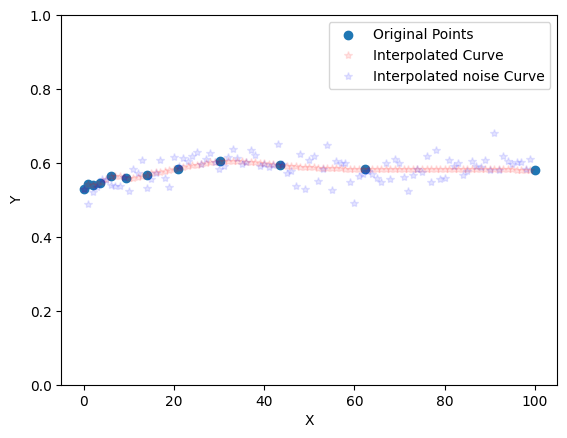

anchors (12,)
means (12,)
y_noise (100,)
y_smooth (100,)
types: <class 'numpy.ndarray'>
types: <class 'numpy.ndarray'>


In [30]:
def get_validation_curve(rng:np.random):
    """Retrieve the validation curve for a given model and dataset."""
    #slect a random row from the dataframe
    row = rng.choice(len(df_train)-1)
    row = df_train.iloc[row]
    #get the openml id
    openlid = row['openmlid']
    learner = row['learner']
    anchors = row['anchors']
    means = row['means']
    std = row['std']
    return anchors, means, std, openlid, learner

# Create a function that generates a batch of samples from the LCBD dataset
def sample_from_lcbd(n:np.random, plot=False, seq_len=100):
    return sample(n, components=None, distribution=None, plot=plot)


def sample(rng:np.random,
            components,
            distribution,
            var_lnloc=-4,
            var_lnscale=1,
            range_constraint=True,
            seq_len=100,
            plot=False):

    anchors, means, std, openmlid, learner = get_validation_curve(rng=rng)

    means = np.array(means)
    #change the anchors to be between 0 and 1
    anchors = np.array(anchors)
    anchors = (anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))
    try:
        f = interp1d(anchors, means, kind='cubic')
    except Exception as e:
        print(f"openmlid: {openmlid}, learner: {learner}")
        print(e)
        f = interp1d(anchors, means)

    x_smooth = np.linspace(min(anchors), max(anchors), seq_len)
    y_smooth = f(x_smooth)
    y_smooth = np.clip(y_smooth, 0, 1)
    y_smooth = y_smooth-0.000000001

    y_noise = rng.normal(0, std, seq_len)
    y_noise = y_smooth + y_noise
    y_noise = np.clip(y_noise, 0, 1)
    y_noise = y_noise-0.000000001

    if plot:
        plt.scatter(anchors*100, means, label='Original Points')
        plt.plot(y_smooth, "*" ,label='Interpolated Curve', color='red', alpha=0.1)
        plt.plot(y_noise,  "*", label='Interpolated noise Curve', color='blue', alpha=0.1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

        print("anchors", anchors.shape)
        print("means", means.shape)
        print("y_noise", y_noise.shape)
        print("y_smooth", y_smooth.shape)
        print("types:", type(y_smooth))
        print("types:", type(y_noise))


    def curve():
        return y_smooth, y_noise
    return curve


y = sample_from_lcbd(np.random, plot=True)


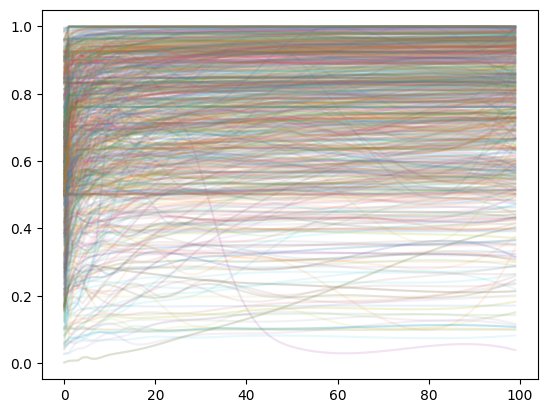

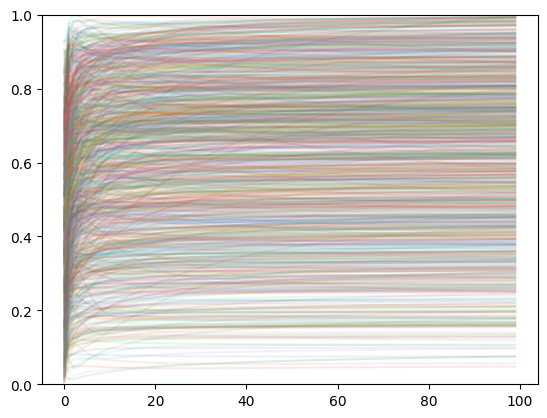

In [31]:
for _ in range(1000):
    prior = sample_from_lcbd(np.random)
    curve, a = prior()
    plt.plot(curve, alpha=0.1)
plt.show()

for _ in range(1000):
    prior = lcpfn.sample_from_prior(np.random)
    curve, a = prior()
    plt.plot(curve, alpha=0.1)
plt.ylim(0, 1)
plt.show()

## Train a PFN model with the previous learning curve prior

In [32]:
# get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)
get_batch_func = lcpfn.create_get_batch_func(prior=sample_from_lcbd)
# lcpfn.sample_from_prior or sample_from_lcbd

In [33]:
# example of a batch
X, Y, y_noise = get_batch_func(batch_size=100, seq_len=100, num_features=1)
print(X.shape, Y.shape, y_noise.shape)


torch.Size([100, 100, 1]) torch.Size([100, 100]) torch.Size([100, 100])


In [34]:
# Main function to train a PFN model
lcpfn.train_lcpfn

<function lcpfn.lcpfn.train_lcpfn.train_lcpfn(get_batch_func, seq_len: int = 100, emsize: int = 512, nlayers: int = 12, num_borders: int = 1000, lr: float = 0.001, batch_size: int = 100, epochs: int = 100)>

In [35]:
# train a small model for 3 epochs
result = lcpfn.train_lcpfn(get_batch_func=get_batch_func,
                          seq_len=100,
                         emsize=256,
                         nlayers=3,
                         num_borders=100,
                         lr=0.001,
                         batch_size=10,
                         epochs=100)

openmlid: 293, learner: sklearn.naive_bayes.MultinomialNB
The number of derivatives at boundaries does not match: expected 1, got 0+0
Using 1000000 y evals to estimate 100 buckets. Cut off the last 0 ys.
checking
Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 10, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7f243e1cc280>, 'seq_len_maximum': 100, 'device': 'cuda:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
Style definition: None
Using a Transformer with 1.77 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.90s | mean loss -0.43 | pos losses   nan,  nan,-0.14,-0.48,-0.40,-0.48,-0.65,-0.14,  nan,-0.10,-0.56,  nan,-0.47,-0.28,  nan,-0.50,-0.47,-0.34,  nan,-0.37,  nan,  nan,-0.41,  nan,-0.30,  nan,-0.38,-0.41,  nan,-0.45,  nan,  nan,-0.59,  nan,  nan,  nan,-0.26, 0.08,-0.4

In [36]:
# Get the trained model

model = result[2]
print(model)

torch.save(model, '/mnt/c/Users/prath/PycharmProjects/rp/temp.pt')
model = lcpfn.LCPFN(model_name="/mnt/c/Users/prath/PycharmProjects/rp/temp.pt")

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dro

torch.Size([99, 1]) torch.Size([100, 1])


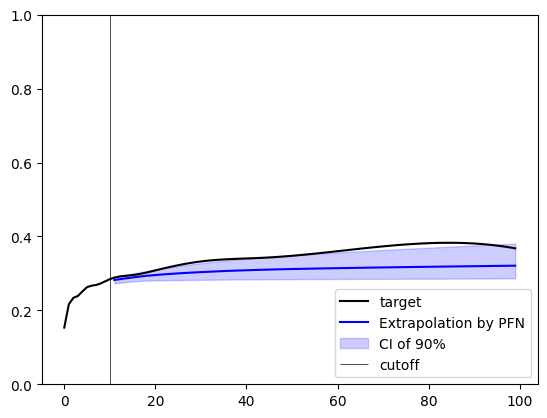

In [37]:
prior = sample_from_lcbd(np.random)
curve, _ = prior()

x = torch.arange(1, 100).unsqueeze(1)
y = torch.from_numpy(curve).float().unsqueeze(1)
cutoff = 10

print(x.shape, y.shape)
model = lcpfn.LCPFN()
predictions = model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

# plot data
plt.plot(curve, "black", label="target")

# plot extrapolation
plt.plot(x[cutoff:], predictions[:, 1], "blue", label="Extrapolation by PFN")
plt.fill_between(
        x[cutoff:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
)

# plot cutoff
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")
